# Daily Electricity Demand Forecast

In [1]:
''' 
In this notebook, we train XGBoost and Prophet models on our datasets and we get a MAPE of 1.37 % and 3.92% respectively, 
and an R2 score of 0.592 and 0.546 respectively

'''

' \nIn this notebook, we train XGBoost and Prophet models on our datasets and we get a MAPE of 1.37 % and 3.92% respectively, \nand an R2 score of 0.592 and 0.546 respectively\n\n'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import xgboost as xgb
from prophet import Prophet

from sklearn.metrics import r2_score

In [3]:
def mean_absolute_percent_error(y_true,y_pred):
    total = np.sum(np.divide(np.array(y_pred),np.array(y_true)))
    return 100*np.abs((len(y_true))-total)/len(y_true)

In [4]:
''' 
This block of code was taken from :
https://www.kaggle.com/code/manualrg/daily-electricity-demand-forecast-machine-learning/notebook

'''

data = pd.read_csv("/kaggle/input/spanish-electricity-market-demand-gen-price/spain_energy_market.csv", sep=",", parse_dates=["datetime"])
data = data[data["name"]=="Demanda programada PBF total"]
data["date"] = data["datetime"].dt.date
data.set_index("date", inplace=True)
data = data[["value"]]
data = data.asfreq("D")
data = data.rename(columns={"value": "Energy_in_MWh"})
data.head()     

,Energy_in_MWh
date,
2014-01-01,620107.7
2014-01-02,659865.2
2014-01-03,632536.8
2014-01-04,610251.7
2014-01-05,572534.1


<AxesSubplot:title={'center':'Power consumption in MW'}, xlabel='date'>

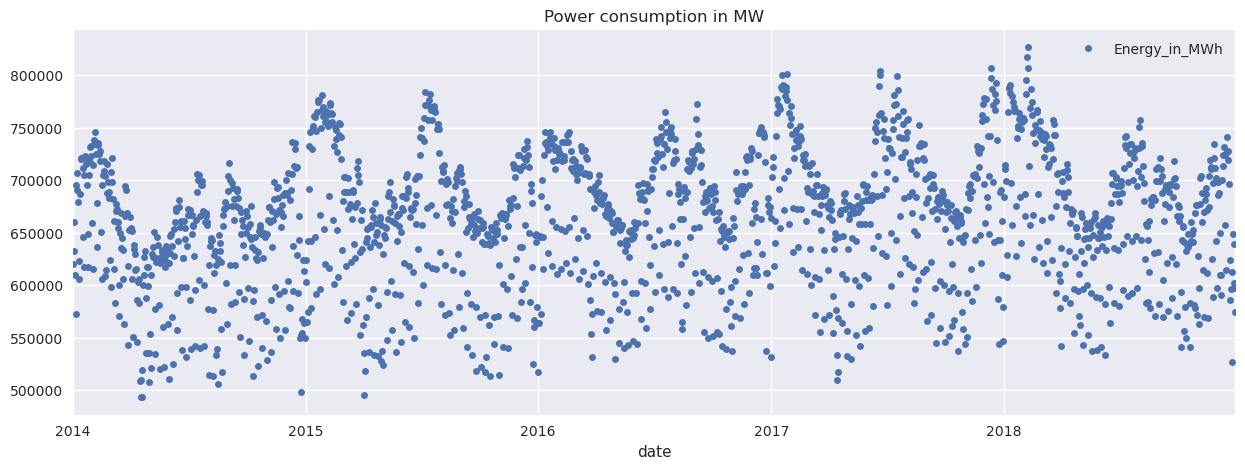

In [5]:
data.plot(style='.',figsize = (15,5),ms=10,title = 'Power consumption in MW')

In [6]:
def create_timeseries_features(df):
    '''
    This function creates timseries features from datetime index of our dataframe
    
    '''
    df = df.copy()
    df['date'] = df.index
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    return df

In [7]:
data = create_timeseries_features(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


<AxesSubplot:xlabel='Energy_in_MWh', ylabel='Count'>

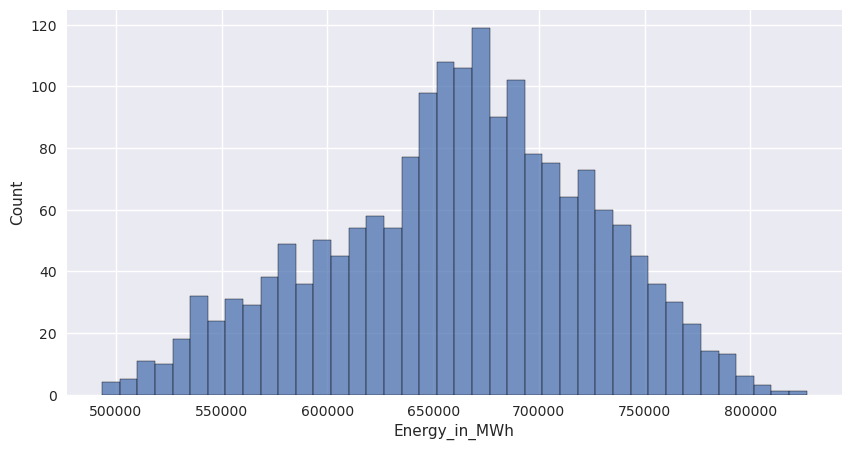

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=data,x='Energy_in_MWh',bins=40)

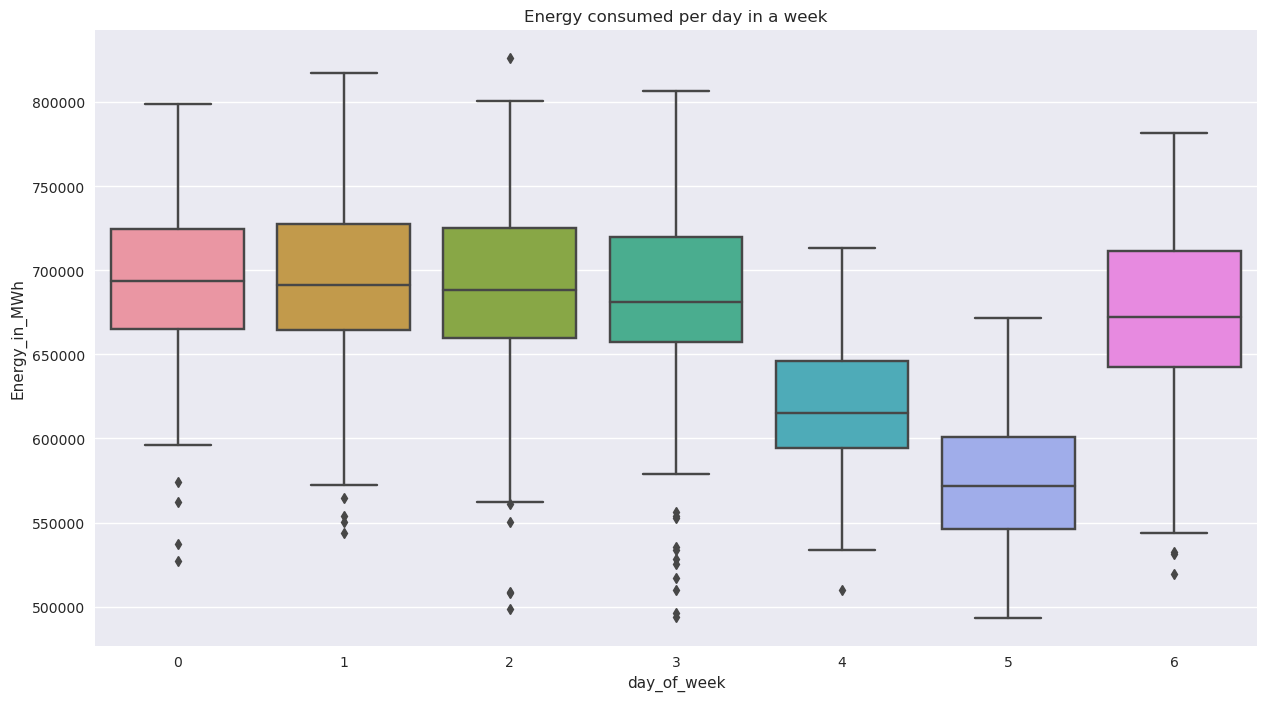

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='day_of_week', y='Energy_in_MWh')
ax.set_title('Energy consumed per day in a week')
plt.show()

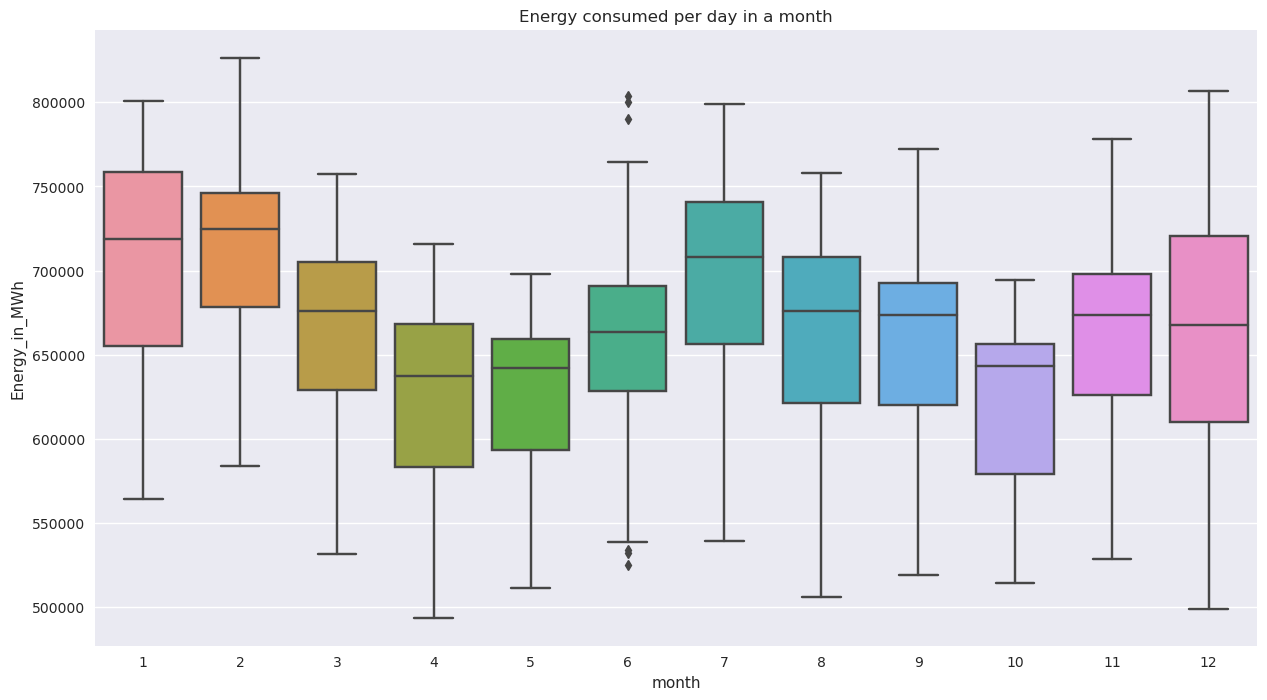

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='month', y='Energy_in_MWh')
ax.set_title('Energy consumed per day in a month')
plt.show()

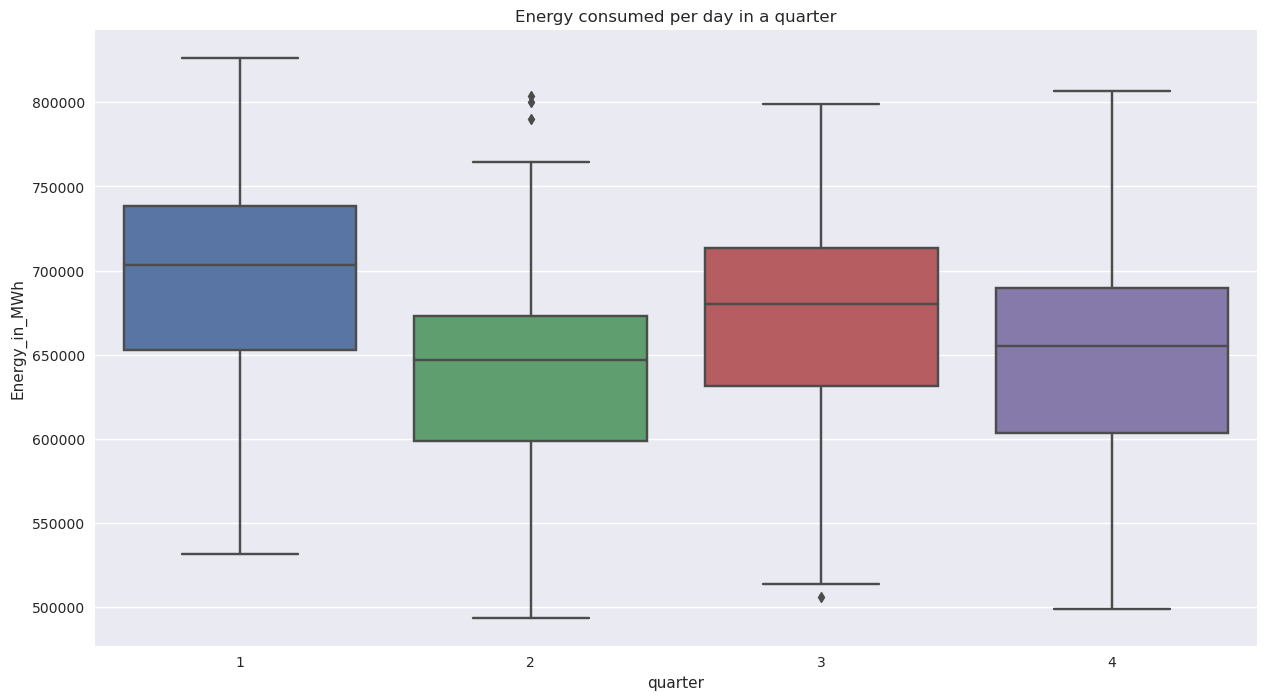

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='quarter', y='Energy_in_MWh')
ax.set_title('Energy consumed per day in a quarter')
plt.show()

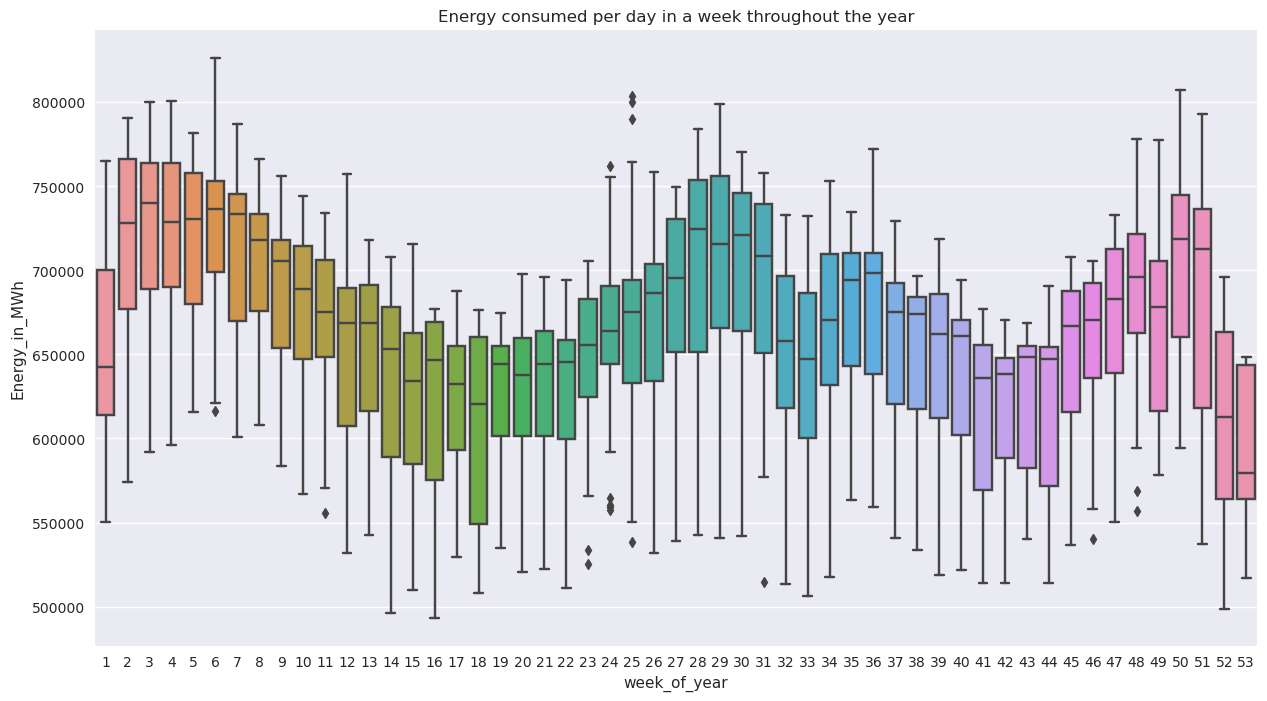

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='week_of_year', y='Energy_in_MWh')
ax.set_title('Energy consumed per day in a week throughout the year')
plt.show()

## Preparing the data for training

In [13]:
train = data.loc[data.index < '01-01-2018']
test = data.loc[data.index >= '01-01-2018']

train.drop(['date'],axis=1,inplace=True)
test.drop(['date'],axis=1,inplace=True)

X_train = train.drop(['Energy_in_MWh'],axis=1)
y_train = train['Energy_in_MWh']

X_test = test.drop(['Energy_in_MWh'],axis=1)
y_test = test['Energy_in_MWh']

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


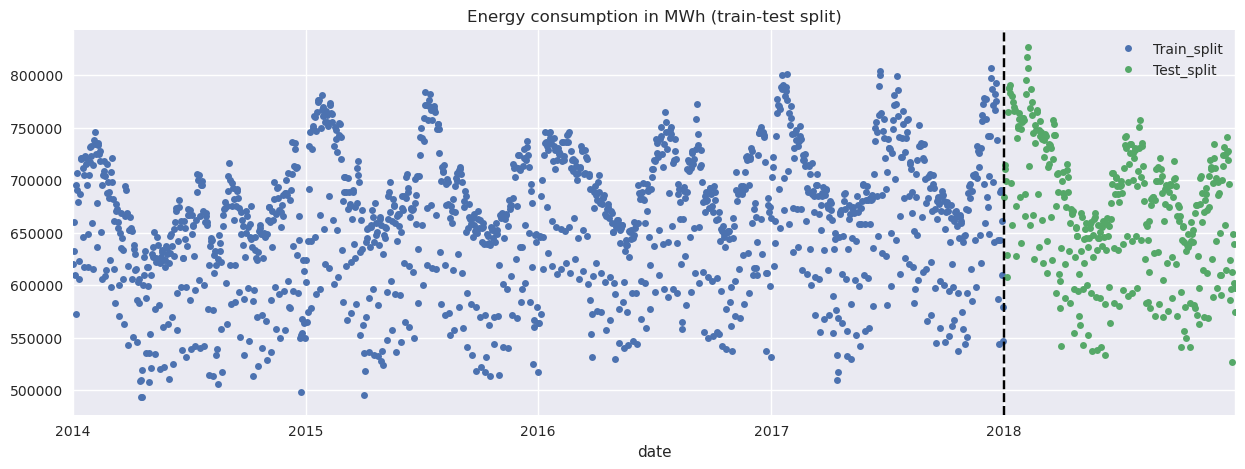

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
train['Energy_in_MWh'].plot(ax=ax,style='.',label='Train_split',ms=10, title='Energy consumption in MWh (train-test split)')
test['Energy_in_MWh'].plot(ax=ax,style='.',label='Test_split',ms=10)
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend()
plt.show()

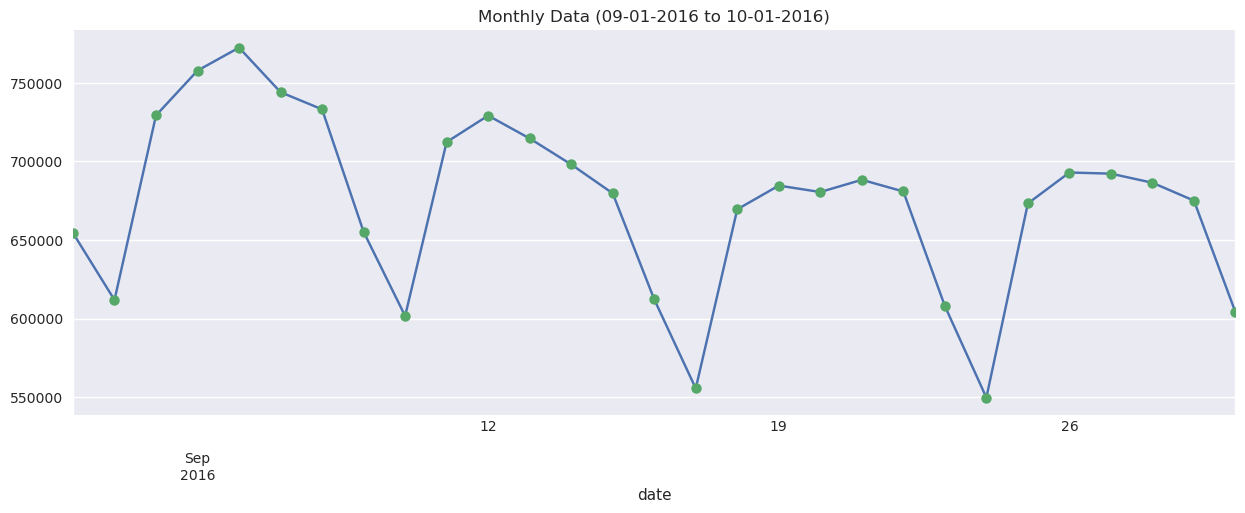

In [15]:
'''
Taking a look at the monthly trend

'''
monthly_data = data['Energy_in_MWh'].loc[(data.index > '09-01-2016') & (data.index < '10-01-2016')] 
monthly_data.plot(figsize=(15, 5), title='Monthly Data (09-01-2016 to 10-01-2016)')
monthly_data.plot(style='.',ms=15,figsize=(15, 5), title='Monthly Data (09-01-2016 to 10-01-2016)')
plt.show()

## Creating XGBoost model

In [16]:
model = xgb.XGBRegressor()
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [17]:
y_test_predicted = model.predict(X_test)

In [18]:
y_testing_df = pd.DataFrame()
y_testing_df['y_test'] = y_test
y_testing_df['y_test_predicted'] = y_test_predicted

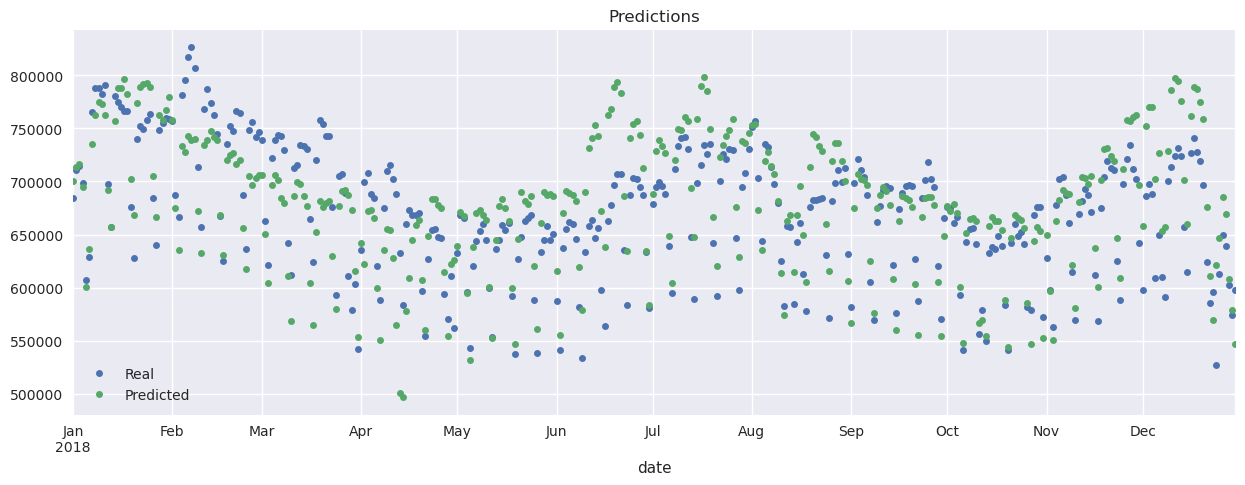

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
y_testing_df['y_test'].plot(ax=ax,style='.',ms=10,label='Real',title='Predictions')
y_testing_df['y_test_predicted'].plot(ax=ax,style='.',ms=10,label='Predicted')
ax.legend()
plt.show()

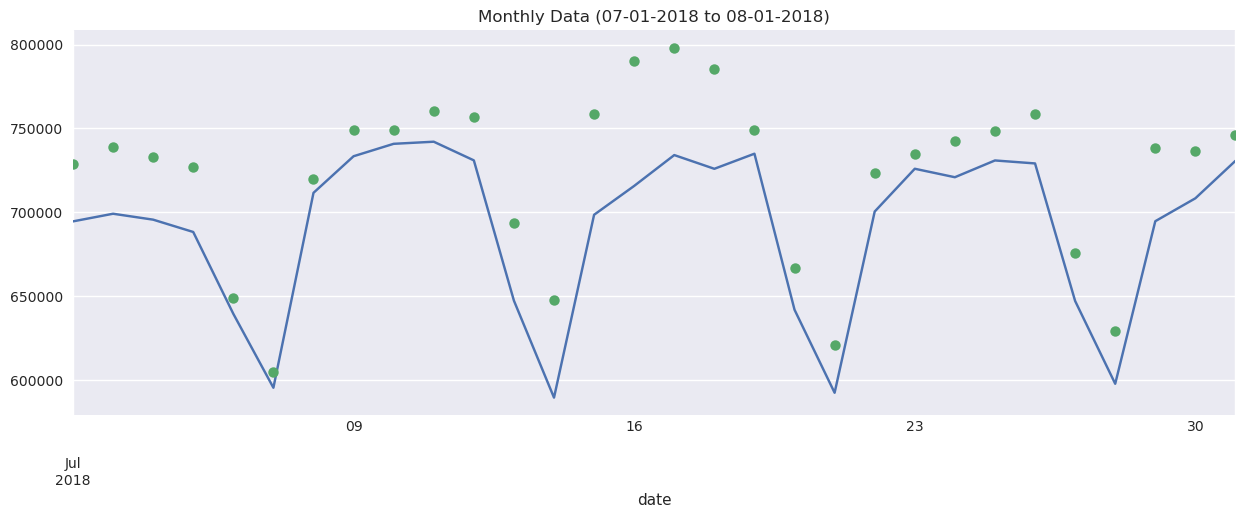

In [20]:
'''
Taking a look at the monthly trend

'''
monthly_data_true = y_testing_df['y_test'].loc[(y_testing_df['y_test'].index > '07-01-2018') & (y_testing_df['y_test'].index < '08-01-2018')] 
monthly_data_predicted = y_testing_df['y_test_predicted'].loc[(y_testing_df['y_test_predicted'].index > '07-01-2018') & (y_testing_df['y_test_predicted'].index < '08-01-2018')]
monthly_data_true.plot(figsize=(15, 5), label='Real',title='Monthly Data (07-01-2018 to 08-01-2018)')
monthly_data_predicted.plot(style='.',ms=15,figsize=(15, 5),label='Predicted')
ax.legend(['Truth Data','Prediction'])
plt.show()

In [21]:
print('mean_absolute_percent_error is : ',mean_absolute_percent_error(y_testing_df['y_test'],y_testing_df['y_test_predicted']),'%')

mean_absolute_percent_error is :  1.373348381992945 %


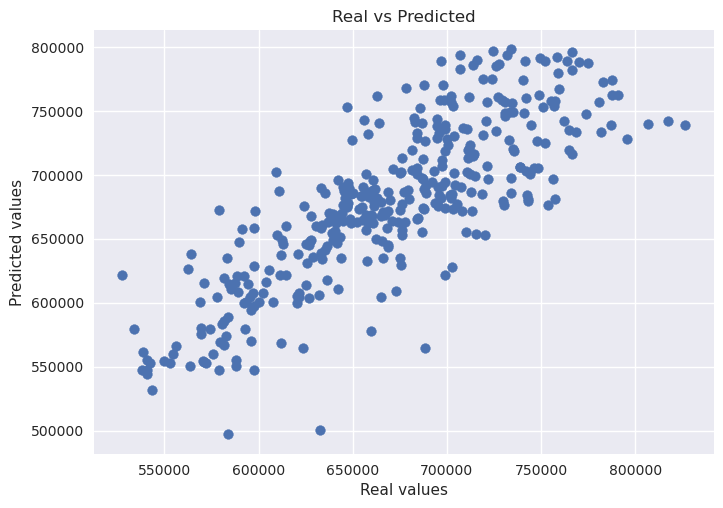

<Figure size 1500x500 with 0 Axes>

In [22]:
plt.scatter(y_testing_df['y_test'],y_testing_df['y_test_predicted'])
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('Real vs Predicted')
plt.figure(figsize=(15,5))
plt.show()

In [23]:
print('r2_score of our model is : ',r2_score(y_testing_df['y_test'],y_testing_df['y_test_predicted']))

r2_score of our model is :  0.5946261371837399


## Creating Prophet model

In [24]:
# Formating the data for prophet model
train_prophet = train.reset_index().rename(columns={'date':'ds','Energy_in_MWh':'y'})

In [25]:
%%time
model = Prophet()
model.fit(train_prophet)

09:42:26 - cmdstanpy - INFO - Chain [1] start processing
09:42:26 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.19 s, sys: 121 ms, total: 1.31 s
Wall time: 1.99 s


In [26]:
test_prophet = test.reset_index().rename(columns={'date':'ds','Energy_in_MWh':'y'})

predictions_prophet = model.predict(test_prophet)
predictions_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,686548.417006,657070.574255,732130.751474,686548.417006,686548.417006,7970.006529,7970.006529,7970.006529,32804.530734,32804.530734,32804.530734,-24834.524205,-24834.524205,-24834.524205,0.0,0.0,0.0,694518.423535
1,2018-01-02,686592.058402,663755.529929,734089.164686,686592.058402,686592.058402,11572.234920,11572.234920,11572.234920,33388.450585,33388.450585,33388.450585,-21816.215664,-21816.215664,-21816.215664,0.0,0.0,0.0,698164.293322
2,2018-01-03,686635.699798,659916.205776,732449.614250,686635.699798,686635.699798,10654.654921,10654.654921,10654.654921,28771.697025,28771.697025,28771.697025,-18117.042104,-18117.042104,-18117.042104,0.0,0.0,0.0,697290.354719
3,2018-01-04,686679.341193,658263.764312,733039.570332,686679.341193,686679.341193,8030.642176,8030.642176,8030.642176,21817.829719,21817.829719,21817.829719,-13787.187543,-13787.187543,-13787.187543,0.0,0.0,0.0,694709.983369
4,2018-01-05,686722.982589,602211.517175,673093.065993,686722.982589,686722.982589,-51122.073394,-51122.073394,-51122.073394,-42232.883137,-42232.883137,-42232.883137,-8889.190256,-8889.190256,-8889.190256,0.0,0.0,0.0,635600.909195


In [27]:
# Creating a dataframe with datetime type index for our ease
predictions_prophet_dt = predictions_prophet.copy()
predictions_prophet_dt["date"] = predictions_prophet_dt["ds"].dt.date
predictions_prophet_dt.set_index("date", inplace=True)
predictions_prophet_dt.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
date,,,,,,,,,,,,,,,,,,,
2018-01-01,2018-01-01,686548.417006,657070.574255,732130.751474,686548.417006,686548.417006,7970.006529,7970.006529,7970.006529,32804.530734,32804.530734,32804.530734,-24834.524205,-24834.524205,-24834.524205,0.0,0.0,0.0,694518.423535
2018-01-02,2018-01-02,686592.058402,663755.529929,734089.164686,686592.058402,686592.058402,11572.234920,11572.234920,11572.234920,33388.450585,33388.450585,33388.450585,-21816.215664,-21816.215664,-21816.215664,0.0,0.0,0.0,698164.293322
2018-01-03,2018-01-03,686635.699798,659916.205776,732449.614250,686635.699798,686635.699798,10654.654921,10654.654921,10654.654921,28771.697025,28771.697025,28771.697025,-18117.042104,-18117.042104,-18117.042104,0.0,0.0,0.0,697290.354719
2018-01-04,2018-01-04,686679.341193,658263.764312,733039.570332,686679.341193,686679.341193,8030.642176,8030.642176,8030.642176,21817.829719,21817.829719,21817.829719,-13787.187543,-13787.187543,-13787.187543,0.0,0.0,0.0,694709.983369
2018-01-05,2018-01-05,686722.982589,602211.517175,673093.065993,686722.982589,686722.982589,-51122.073394,-51122.073394,-51122.073394,-42232.883137,-42232.883137,-42232.883137,-8889.190256,-8889.190256,-8889.190256,0.0,0.0,0.0,635600.909195


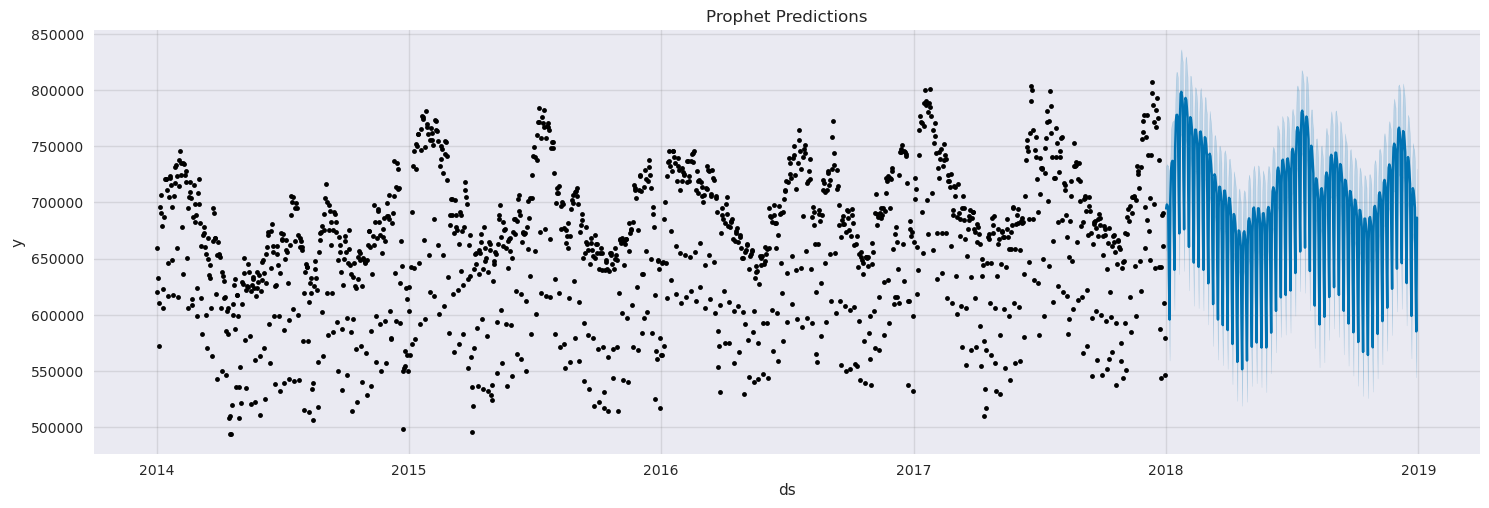

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
fig = model.plot(predictions_prophet, ax=ax)
ax.set_title('Prophet Predictions')
plt.show()

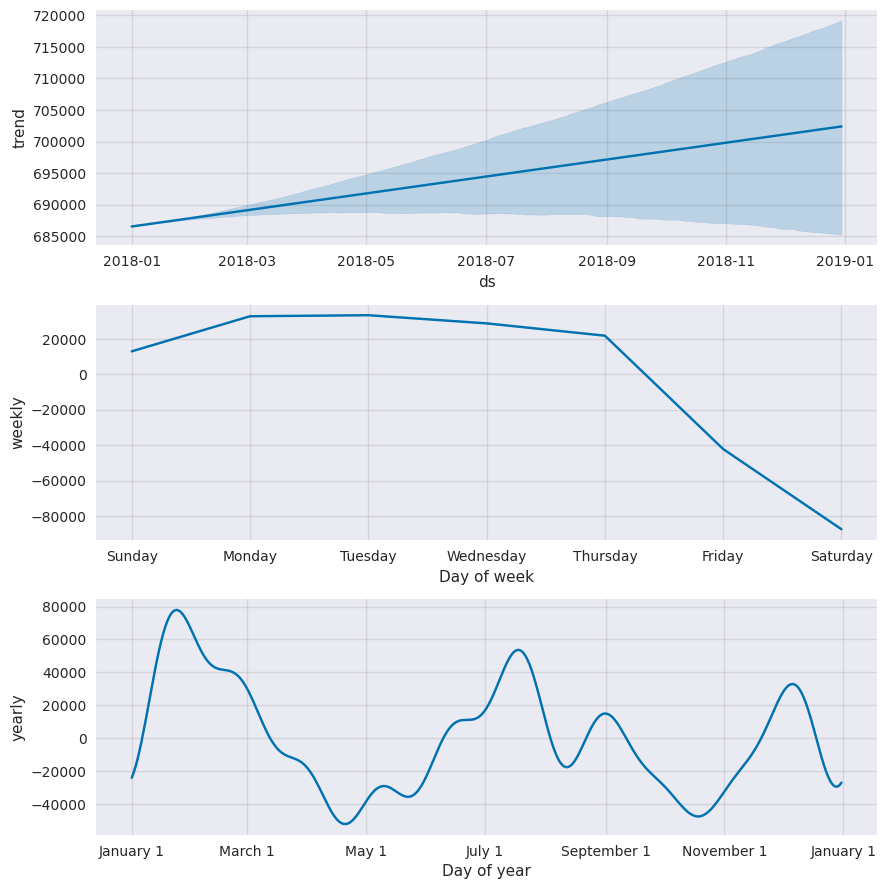

In [29]:
fig = model.plot_components(predictions_prophet)
plt.show()

In [30]:
print('mean_absolute_percent_error is : ',mean_absolute_percent_error(y_testing_df['y_test'],predictions_prophet_dt['yhat']),'%')

mean_absolute_percent_error is :  3.925930997079136 %


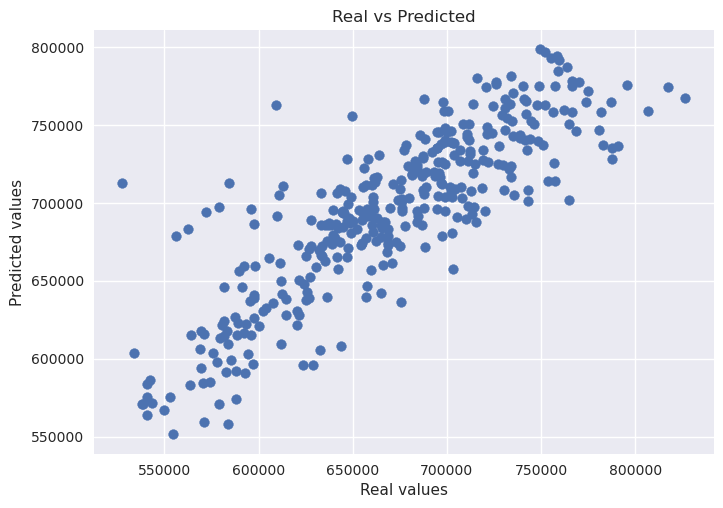

<Figure size 1500x500 with 0 Axes>

In [31]:
plt.scatter(y_testing_df['y_test'],predictions_prophet_dt['yhat'])
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('Real vs Predicted')
plt.figure(figsize=(15,5))
plt.show()

In [32]:
print('r2_score of our model is : ',r2_score(y_testing_df['y_test'],predictions_prophet_dt['yhat']))

r2_score of our model is :  0.5463341928078307
